# Lista 2

Disciplina: ELE08624 - Tópicos Especiais em Processamento de Imagens

Semestre: 2020/1 - especial

Aluno: Gabriel Carvalho Benedito

Matrícula: 2013100874

## Imports

In [32]:
# imports
import cmath
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import image, colors
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
import numpy as np
import PIL
from scipy.fft import fft2, fftshift, ifft2

## Funções personalizadas

In [33]:
# NOTE: all custom function assumes normalized images on range [0, 1]

def plot_img_gray(img, title=None):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis('off')

# plots an grayscale image
def plot_img(img, title=None):
    fig, ax = plt.subplots()
    ax.imshow(img, vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis('off')

# plots input and output images
# TODO
def plot_img_in_out(img_in, img_out):
    fig, axs = plt.subplots(1, 2)
    # input image
    axs[0].imshow(img_in, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title('Entrada')
    axs[0].axis('off')
    # output image
    axs[1].imshow(img_out, cmap='gray', vmin=0, vmax=1)
    axs[1].set_title('Saída')
    axs[1].axis('off')

# plots input and output images
# TODO
def plot_spectrum(img):
    fig, axs = plt.subplots(1, 3)
    # input image
    axs[0].imshow(img, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title('Entrada')
    axs[0].axis('off')
    # fft2
    img_fft2_abs, img_fft2_angle = fft2_polar(img)
    # abs
    axs[1].imshow(img_fft2_abs, cmap='gray', norm=LogNorm())
    axs[1].set_title('Módulo')
    axs[1].axis('off')
    # angle
    axs[2].imshow(img_fft2_angle, cmap='gray', vmin=-np.pi, vmax=np.pi)
    axs[2].set_title('Fase')
    axs[2].axis('off')

# plots an frequency and density histogram
# TODO
def plot_hist(img, n_bins=30):
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Histograma')
    plt.subplots_adjust(wspace=0.39)
    # vetorize image (transform to 1D-vector)
    vect_img = np.reshape(img, (-1))
    # stats
    img_mean = np.mean(vect_img)
    img_median = np.median(vect_img)
    mean_label = 'Média = {:.2f}'.format(img_mean)
    median_label = 'Mediana = {:.2f}'.format(img_median)
    # frequencies
    axs[0].hist(vect_img, bins=n_bins)
    axs[0].axvline(img_mean, c='g', label=mean_label)
    axs[0].axvline(img_median, c='r', label=median_label)
    axs[0].legend(fontsize='xx-small')
    axs[0].set_xlim(0, 1)
    axs[0].set_ylabel('Número de pixels')
    axs[0].set_xlabel('Intensidade [0, 1]')
    # density
    weights = np.ones_like(vect_img) / vect_img.size
    axs[1].hist(vect_img, bins=n_bins, weights=weights)
    axs[1].axvline(img_mean, c='g', label=mean_label)
    axs[1].axvline(img_median, c='r', label=median_label)
    axs[1].legend(fontsize='xx-small')
    axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
    axs[1].set_xlim(0, 1)
    axs[1].set_ylabel('Densidade')
    axs[1].set_xlabel('Intensidade [0, 1]')

# according to exercice 4 specification
# TODO
def spatial_conv(a, kernel_func, kernel_size=1, padding=False, mode='constant', **kwargs):
    # neighborhood range of kernel along each axis, considering a central pixel and without conting it
    kernel_offset = int((kernel_size - 1) / 2)
    # compute input
    if not padding:
        # just copy
        a_in = np.copy(a)
    else:
        # pad width
        pad_width = kernel_offset
        # apply padding given numpy possibilities
        a_in = np.pad(a, pad_width, mode, **kwargs)
    # initialize output
    b_out_shape = (a_in.shape[0] - kernel_size + 1, a_in.shape[1] - kernel_size + 1)
    b_out = np.empty(b_out_shape, dtype=a_in.dtype)
    # iterate over rows and coluns
    for r_out, r_in in enumerate(range(kernel_offset, a_in.shape[0] - kernel_offset)):
        for c_out, c_in in enumerate(range(kernel_offset, a_in.shape[1] - kernel_offset)):
            # kernel as neighborhood of input
            kernel = a_in[r_in-kernel_offset:r_in+kernel_offset+1, c_in-kernel_offset:c_in+kernel_offset+1]
            # apply kernel function
            b_out[r_out, c_out] = kernel_func(kernel)
    return b_out

# element-wise polar-rect complex transform
# TODO
def rect(x_abs, x_angle):
    x = np.empty_like(x_abs).astype(complex)
    for r in range(x_abs.shape[0]):
        for c in range(x_abs.shape[1]):
            x[r, c] = cmath.rect(x_abs[r, c], x_angle[r, c])
    return x

# polar components of dft of x (applies fftshift before returning)
# TODO
def fft2_polar(x):
    x_fft2 = fftshift(fft2(x))
    return np.abs(x_fft2), np.angle(x_fft2)

# inverse dft of x from polar components (applies fftshift before computing)
# TODO
def real_ifft2_polar(x_abs, x_angle):
    return np.real(ifft2(fftshift(rect(x_abs, x_angle))))

## Exercício 1

Faça uma rotina que converta RGB-HSI e outra de HSI-RGB. Depois, usando essas transformadas, substitua, automaticamente, a cor das laranjas para verde na imagem [oranges.jpg](img/oranges.jpg). Discuta a sua solução.

### Imagem de entrada

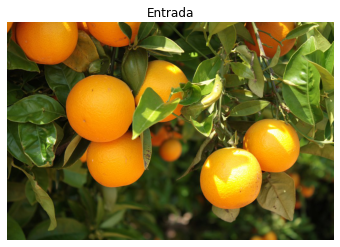

In [34]:
# open image
img = image.imread('img/oranges.jpg')
# transforms
# normalization
img = img / 255
# plot
plot_img(img, 'Entrada')

In [76]:
def rgb_to_hsi(img):
    # eps
    eps = np.finfo(np.float32).eps
    # transforms
    theta = lambda r, g, b: np.arccos(.5*((r-g)+(r-b)+eps)/(np.sqrt(np.power((r-g),2)+(r-b)*(g-b))+eps))
    h = lambda r, g, b: (theta(r, g, b) if b <= g else 2*np.pi-theta(r, g, b))/(2*np.pi)
    s = lambda r, g, b: 1-(3./(r+g+b))*np.min([r,g,b])
    i = lambda r, g, b: (r+g+b)/3
    # output
    hsi = np.empty_like(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            r = img[x,y,0]
            g = img[x,y,1]
            b = img[x,y,2]
            hsi[x,y,0] = h(r,g,b)
            hsi[x,y,1] = s(r,g,b)
            hsi[x,y,2] = i(r,g,b)
    return hsi

def hsi_to_rgb(img):
    # eps
    eps = np.finfo(np.float32).eps
    # transforms
    t_1 = lambda h, s, i: i*(1-s)
    t_2 = lambda h, s, i: i*(1+((s*np.cos(h))/np.cos((np.pi/3)-h)))
    t_3 = lambda h, s, i: 3*i-(t_1(h,s,i)+t_2(h,s,i))
    r = lambda h, s, i: t_2(h,s,i) if h >= 0 and h < 2*np.pi/3 else (t_1(h-2*np.pi/3,s,i) if h >= 2*np.pi/3 and h < 4*np.pi/3 else t_3(h-4*np.pi/3,s,i))
    g = lambda h, s, i: t_3(h,s,i) if h >= 0 and h < 2*np.pi/3 else (t_2(h-2*np.pi/3,s,i) if h >= 2*np.pi/3 and h < 4*np.pi/3 else t_1(h-4*np.pi/3,s,i))
    b = lambda h, s, i: t_1(h,s,i) if h >= 0 and h < 2*np.pi/3 else (t_3(h-2*np.pi/3,s,i) if h >= 2*np.pi/3 and h < 4*np.pi/3 else t_2(h-4*np.pi/3,s,i))
    # output
    rgb = np.empty_like(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            h = img[x,y,0]*2*np.pi
            s = img[x,y,1]
            i = img[x,y,2]
            rgb[x,y,0] = r(h,s,i)
            rgb[x,y,1] = g(h,s,i)
            rgb[x,y,2] = b(h,s,i)
    return rgb

3
[[[0.90980392 0.49019608 0.80392157]]]
[[[0.9098039  0.49019608 0.80392159]]]
True


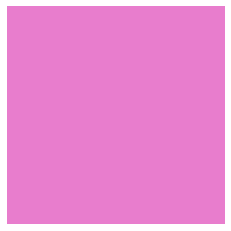

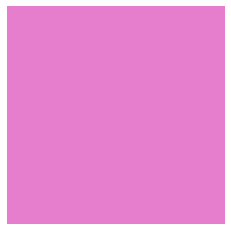

In [78]:
# r, g, b = 232, 200, 125
# r, g, b = 125, 232, 200
r, g, b = 232, 125, 205

original_color = np.array([[[r, g, b]]])/255
plot_img(original_color)

hsi_color = rgb_to_hsi(original_color)
rgb_color = hsi_to_rgb(hsi_color)
plot_img(rgb_color)
h = hsi_color[0,0,0] *2*np.pi
print(1 if h >= 0 and h < 2*np.pi/3 else (2 if h >= 2*np.pi/3 and h < 4*np.pi/3 else 3))
print(original_color)
print(rgb_color)
print(np.allclose(original_color, rgb_color))

In [79]:
img_hsi = rgb_to_hsi(img)
img_rgb = hsi_to_rgb(img)

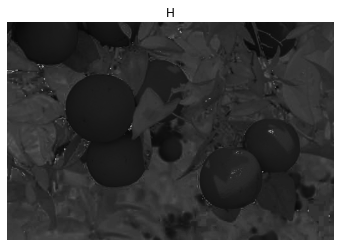

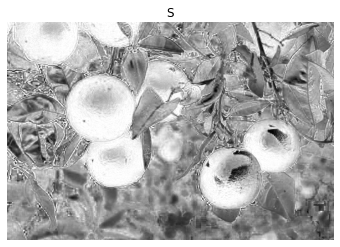

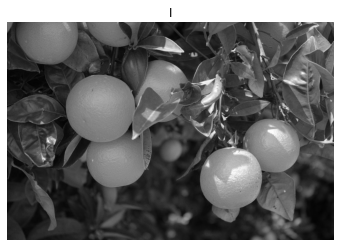

In [80]:
plot_img_gray(img_hsi[:,:,0], 'H')
plot_img_gray(img_hsi[:,:,1], 'S')
plot_img_gray(img_hsi[:,:,2], 'I')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


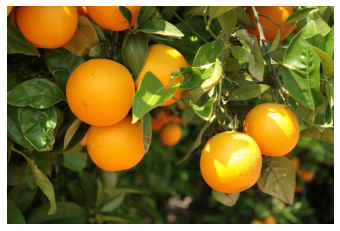

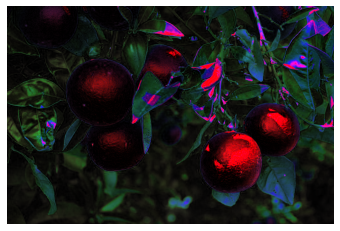

In [81]:
plot_img(img)
plot_img(img_rgb)

## Exercício 2

Faça uma rotina que deixa a cor dos pimentões vermelhos da figura [peppers.tiff](img/peppers.tiff) sem alteração e que deixe os demais elementos da imagem em nível de cinza. Use a equação de percepção humana de luminosidade para obter o nível de cinza: I = 0.21 R + 0.72 G + 0.07 B. Comente a solução usada e o resultado.

### Imagem de entrada

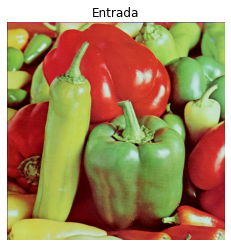

In [4]:
# open image
img = image.imread('img/peppers.tiff')
# transforms
# normalization
img = img / 255
# plot
plot_img(img, 'Entrada')

### Fatiamento de cores

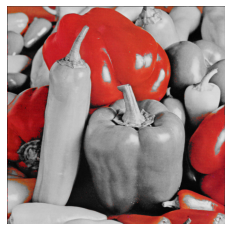

In [5]:
# gray transform and transform output shape
gray_t = np.array([.21, .72, 0.07])
t_out_shape = (img.shape[0], img.shape[1], -1)
# non red mask
color = np.array([1, 0, 0], dtype=img.dtype)
radius = .55
non_red_mask = np.linalg.norm(img - color, axis=2) > radius
# apply op
img_out = np.copy(img)
img_out[non_red_mask] = (np.dot(img_out, gray_t).reshape(t_out_shape))[non_red_mask]
plot_img(img_out)

## Exercício 3

Para a imagem [imsemcontraste.jpg](img/imsemcontraste.jpg), melhore seu contraste. Explique sua solução.

### Imagens de entrada

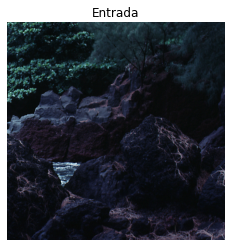

In [62]:
# open image
img = image.imread('img/imsemcontraste.jpg')
# transforms
# normalization
img = img / 255
# plot
plot_img(img, 'Entrada')

## Exercício 4

Usando a transformada de Hough, encontre as linhas brancas nos limites da estrada na imagem [estrada.png](img/estrada.png). Discuta a solução encontrada.

### Imagem de entrada

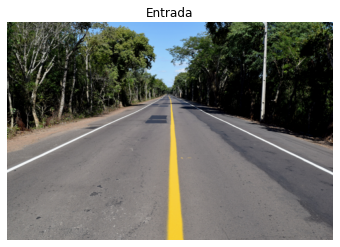

In [40]:
# open image
img = image.imread('img/estrada.png')
# remove alpha channel
img = img[:,:,:3]
# plot
plot_img(img, 'Entrada')

### Selecionando faixa de cores brancas

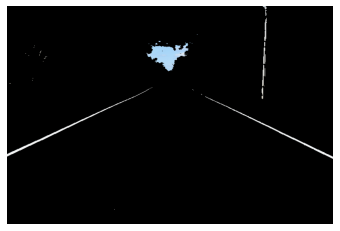

In [41]:
# non white mask
color = np.array([1, 1, 1], dtype=img.dtype)
radius = .4
non_white_mask = np.linalg.norm(img - color, axis=2) > radius
# apply op
img_out = np.copy(img)
img_out[non_white_mask] = 0
plot_img(img_out)

### Transformando em escala de cores de cinza e binarizando

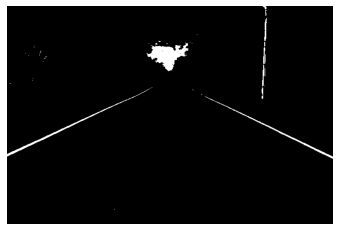

In [42]:
# gray transform and transform output shape
gray_t = np.array([.21, .72, 0.07])
gray_img = np.dot(img_out, gray_t)
bin_img = np.vectorize(lambda x: 1. if x > 0 else 0.)(gray_img)
plot_img_gray(bin_img)

### Detectando bordas de +- 45º

In [43]:
# masks
mask_ur = np.array([[ 0,  1,  2],
                    [-1,  0,  1],
                    [-2, -1,  0]], dtype=bin_img.dtype)
mask_ul = np.rot90(mask_ur)
# apply masks
border_ur_img = spatial_conv(bin_img, lambda x: np.sum(mask_ur*x), kernel_size=3, padding=True)
border_ul_img = spatial_conv(bin_img, lambda x: np.sum(mask_ul*x), kernel_size=3, padding=True)
# abs
border_ur_img = np.abs(border_ur_img)
border_ul_img = np.abs(border_ul_img)

### Aplicando limiar, normalizando, componto e plotando

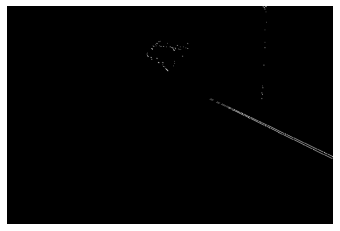

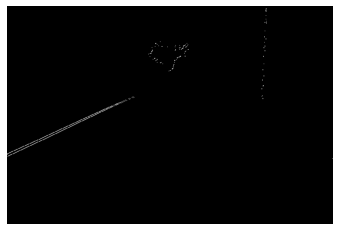

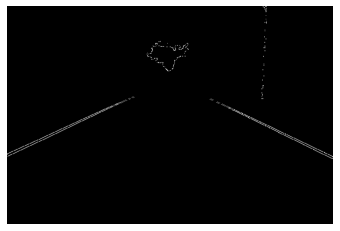

In [44]:
# filter by threshold
threshold = np.max(border_ur_img)
border_ur_img[border_ur_img < threshold] = 0
border_ul_img[border_ul_img < threshold] = 0
# normalize
border_ur_img = border_ur_img/threshold
border_ul_img = border_ul_img/threshold
# sum results
border_img = border_ur_img + border_ul_img
# normalize
border_img = np.vectorize(lambda x: 1. if x >= 1. else 0)(border_img)
# plot
plot_img_gray(border_ur_img)
plot_img_gray(border_ul_img)
plot_img_gray(border_img)

### Transformada de Hough

In [149]:
def line_polar(x, y, theta):
    return x*np.cos(theta) + y*np.sin(theta)

def hough_t(img, rho_per_pixel, theta_per_pixel):
    # mins and maxs
    max_rho = np.ceil(np.sqrt(np.power(img.shape[0], 2) + np.power(img.shape[1], 2))).astype(int)
    min_rho = -max_rho
    min_theta = -np.pi/2
    max_theta = np.pi/2
    # img dims
    theta_count = np.ceil((max_theta - min_theta)/theta_per_pixel).astype(int)
    rho_count = np.ceil((max_rho - min_rho)/rho_per_pixel).astype(int)
    hough_t_out = np.zeros((rho_count, theta_count))
    # theta array
    theta = np.linspace(min_theta, max_theta, num=theta_count)
    # transform
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if img[x, y] == 1:
                rho = line_polar(x, y, theta)
                for r, t in zip(rho, theta):
                    r = int((r - min_rho)/(max_rho - min_rho) * (hough_t_out.shape[0] - 1))
                    t = int((t - min_theta)/(max_theta - min_theta) * (hough_t_out.shape[1] - 1))
                    hough_t_out[r, t] = hough_t_out[r, t] + 1
    return hough_t_out


In [150]:
hough_t_out = hough_t(border_img, 1, np.pi/1440)

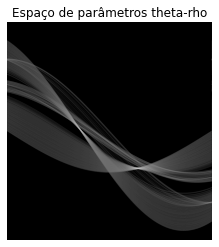

In [151]:
fig, ax = plt.subplots()
ax.imshow(hough_t_out + 1, cmap='gray', norm=LogNorm())
ax.set_title('Espaço de parâmetros theta-rho')
ax.axis('off');

### Detecção das células acumuladoras com valores máximos

In [143]:
def max_rho_theta_of_hough_t(hough_t_out, theta, delta_theta, rho_per_pixel, theta_per_pixel):
    # mins and maxs
    max_rho = int(rho_per_pixel*hough_t_out.shape[0]/2)
    min_rho = -max_rho
    min_theta = -np.pi/2
    max_theta = np.pi/2
    # slice
    hough_t_out_slice = np.copy(hough_t_out)
    t_min = int(((theta - delta_theta) - min_theta)/(max_theta - min_theta) * hough_t_out.shape[1] - 1)
    t_max = int(((theta + delta_theta) - min_theta)/(max_theta - min_theta) * hough_t_out.shape[1])
    hough_t_out_slice = hough_t_out_slice[:, t_min:t_max]
    # get max value of slice
    max_values = []
    c_values = []
    for r in range(hough_t_out_slice.shape[0]):
        # max and argmax
        max_value = np.max(hough_t_out_slice[r,:])
        c = np.argmax(hough_t_out_slice[r,:])
        # record values
        max_values.append(max_value)
        c_values.append(c)
    # single max value
    max_value = np.max(max_values)
    r_max = np.argmax(max_values)
    c_max = c_values[r_max]
    # convert to rho and theta
    rho_max_value = r_max * rho_per_pixel + min_rho
    theta_max_value = (c_max + t_min) * theta_per_pixel + min_theta
    return rho_max_value, theta_max_value



### Assumindo conhecimento parcial do ângulo (+/- 30º) e filtrando em +/- 10º para valores de theta

In [147]:
# left
rho_max_value_l, theta_max_value_l = max_rho_theta_of_hough_t(hough_t_out, (30/180)*np.pi, (10/180)*np.pi, rho_per_pixel, theta_per_pixel)
# right
rho_max_value_r, theta_max_value_r = max_rho_theta_of_hough_t(hough_t_out, (-30/180)*np.pi, (10/180)*np.pi, rho_per_pixel, theta_per_pixel)

In [152]:
print('Faixa da esquerda:')
print('\trho\t=', rho_max_value_l)
print('\ttheta\t=', theta_max_value_l)
print('Faixa da direita:')
print('\trho\t=', rho_max_value_r)
print('\ttheta\t=', theta_max_value_r)

Faixa da esquerda:
	rho	= 263
	heta	= 0.43851397456357555
Faixa da direita:
	rho	= -15
	heta	= -0.4603305902135044


### Linha de coordenadas polares para retangulares

In [145]:
def pol_to_rec_line(rho, theta):
    alpha = - np.cos(theta)/np.sin(theta)
    beta = rho/np.sin(theta)
    return alpha, beta

### Invertendo transformada para os dois valores encontrados e plotando faixas nas imagems (espeçura de 10 pixeis)

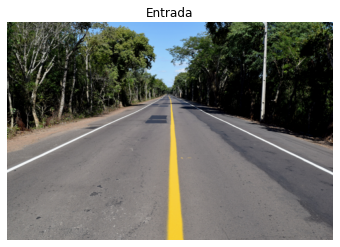

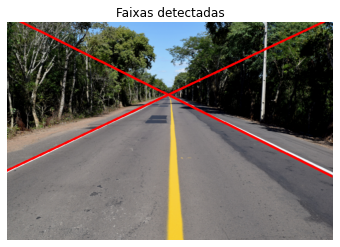

In [154]:
# pol to rec of lines
alpha_l, beta_l = pol_to_rec_line(rho_max_value_l, theta_max_value_l)
alpha_r, beta_r = pol_to_rec_line(rho_max_value_r, theta_max_value_r)
# empty img of lines
lines_img = np.copy(img)
width = 10
for x in range(border_img.shape[0]):
    y_l = int(alpha_l*x + beta_l)
    y_r = int(alpha_r*x + beta_r)
    for current_y in [y_l, y_r]:
        for w in range(width):
            y_min = current_y-w
            y_max = current_y-w+1
            if y_min >= 0 and y_max >= 0 and y_min < lines_img.shape[1] and y_max < lines_img.shape[1]:
                # change color to red
                lines_img[x, y_min:y_max, :] = [1., 0., 0.]
plot_img(img, 'Entrada')
plot_img(lines_img, 'Faixas detectadas')

### Discussão da solução encontrada

Passos:

- removeu o canal alpha por conveniência;
- zerou-se os valores não brancos da imagem dado um raio de 0.4 centrado no branco;
- a imagem foi convertida para níveis de cinza utilizando a fórmula de percepção humana;
- máscaras de valores fixos foram usadas para detectar bordas em +/- 45º;
- a transformada de Hough foi aplicada à imagem para se detectar os faixas laterais da pista;
- vide exemplo do livro, foram assumidos valores de ângulos baseados na perspectiva da imagem para se detectar as células acumuladoras com maiores valores absolutos;
- os valores de rho e theta obtidos para ambas as faixas foram convertidos para coordenadas retangulares;
- baseadas nos valores dos parâmetros das retas, faixas de cor vermelha foram sobrepostas na imagem de entrada indicando as faixas da pista;

Infelizmente foi necessário assumir a perspectiva da imagem. Além disso não se utilizou técnicas para unir pixeis com alta probabilidade de serem pertencentes à uma dada reta.

## Exercício 5

Tente reproduzir o exemplo 10.22 do livro (3ª edição) na imagem [Fig1049(a).tif](img/Fig1049(a).tif) comparando o método de Otsu com o método de médias móveis. Comente.

### Imagem de entrada

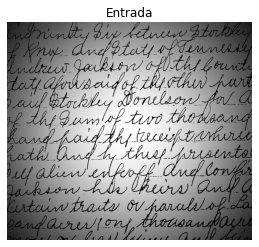

In [69]:
# open image
img = image.imread('img/Fig1049(a).tif')
# transforms
# normalization
img = img / 255
# plot
plot_img_gray(img, 'Entrada')

## Perguntas

### 1) Qual a diferença entre uma imagem com cor falsa e outra com cor verdadeira? Por que em algumas imagens é usada cor falsa?

Cores falsas, também chamadas de pseudocores, são cores criadas a partir de uma imagem em nível de cinza, tendo como principal objetivo visualização e facilitação da compreenção humana do conteúdo de uma imagem. O processo de criação consiste em maperar níveis de cinzas para cores a partir de determinados critérios pré-estabelecidos, conforme o contexto e domínio do problema.

Em contraste, as cores verdadeiras são cores de uma imagem que tentam representar fidedignamente as cores do objeto representado na imagem atraves do processo de captura.

Cores falsas são normalmente utilizadas para auxiliar o processo de compreenção humana na interpretação do conteúdo de imagens.

### 2) Explique o método de Canny.

Dada uma imagem de entrada `f(x,y)`, primeiramente se suavisa-se a imagem por:

- `f_s(x,y) = G(x,y) conv f(x,y)`

onde:

- `G(x,y) = exp^(-(x^2 + y^2)/(2*sigma^2))`

denota a função gaussiana. Em seguida se calcula a magnitude e direção do gradiente, dado por:

- `M(x,y) = sqrt(g_x^2 + g_y^2)`
- `alpha(x,y) = arctg(g_y/g_x)`

onde `g_x` é a primeira derivada parcial de `f_s` em relação à `x` e `g_y` é a primeira derivada parcial de `f_s` em relação à `y`.

Agora aplica-se a supressão não máxima na imagem de magnitude do gradiente, com o objetido de afinar as cristas largas causadas pelo gradiente em torno dos máximos locais. Assim, dada as direções básicas `d1`, `d2`, `d3` e `d4` de uma região 3x3 - ou seja, verical, horizontal e +/-45º - pode-se suprimir não máximos desta região 3x3 centrada em todos os pontos `(x,y)` de `alpha(x,y)` da seguinte forma:

1. Encontramos a direção `d_k` que está mais perto de `alpha(x,y)`;
2. Se o valor de `M(x,y)` for inferior a pelo menos um dos seus dois vizinhos ao longo de `d_k` deixe `g_n(x,y) = 0`; caso contrário, deixe `g_n(x,y) = M(x,y)`

onde `g_n(x,y)` é a imagem com supressão de não máximos.

Por fim, se usa uma dupla limiarização para reduzir fasos pontos de borda. É feita uma limiarização por histerese com dois limiares, sendo um alto `T_H` e outro baixo `T_L`. Assim:

- Se a magnitude do pixel `(x,y)` for maior do que `T_H`, ele é um ponto de borda.
- Se a magnitude do pixel `(x,y)` for maior do que `T_L` e menor do que `T_H`, ele é um candidato a um ponto de borda.
- Se a magnitude do pixel `(x,y)` for menor do que `T_L`, ele é descartado.

Porém deve-se tratar os candidatos a pontos de borda antes de dar o processo como finalizado. Assim, um candidato é considerado como ponto de borda se, e somente se, ele está conectado a um ponto de borda por conectividade-8. Caso contrário, ele é descartado.


### 3) Explique o procedimento de divisão e fusão de região(Seção 10.4.2).

TODO